<a href="https://colab.research.google.com/github/Asaf95/Apple-stock-price-prediction/blob/unite_repo_combine/Apple_Stock_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing modules

In [ ]:
 pip install alpha_vantage

     |████████████████████████████████| 1.1 MB 6.6 MB/s 
     |████████████████████████████████| 144 kB 56.6 MB/s 
     |████████████████████████████████| 94 kB 2.6 MB/s 
     |████████████████████████████████| 271 kB 41.1 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
#import stml_m3
import get_data
#import data_preparation
import lstm_model
import data_prep1
#import aap_02 

# Main

In [ ]:
import pandas as pd

df = pd.read_csv("AAPL_rawdata.csv")
#df = pd.read_csv(data, encoding = "ISO-8859-1")
df = pd.DataFrame(df)
df_newL = df.copy()
df

,date,1. open,2. high,3. low,4. close,5. volume
0,2022-03-28,172.17,175.73,172.00,175.60,90371916.0
1,2022-03-25,173.88,175.28,172.75,174.72,80281664.0
2,2022-03-24,171.06,174.14,170.21,174.07,90131418.0
3,2022-03-23,167.99,172.64,167.65,170.21,98062674.0
4,2022-03-22,165.51,169.42,164.91,168.82,80979755.0
...,...,...,...,...,...,...
5633,1999-11-05,84.62,88.37,84.00,88.31,3721500.0
5634,1999-11-04,82.06,85.37,80.62,83.62,3384700.0
5635,1999-11-03,81.62,83.25,81.00,81.50,2932700.0
5636,1999-11-02,78.00,81.69,77.31,80.25,3564600.0


LSTM Model

In [ ]:
import datetime
def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)
    
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    first_date = str_to_datetime(first_date_str)
    last_date  = str_to_datetime(last_date_str)

    target_date = first_date
    
    dates = []
    X, Y = [], []

    last_time = False
    while True:
      df_subset = dataframe.loc[:target_date].tail(n+1)
      
      if len(df_subset) != n+1:
        print(f'Error: Window of size {n} is too large for date {target_date}')
        return

In [ ]:
def New_LSTM(df, start_time, end_time):
  df_newL = df
  df_newL = df_newL[['Date', 'Close']]
  df_newL['Date']
  import datetime

  datetime_object = str_to_datetime('1986-03-19')
  datetime_object
  df_newL['Date'] = df_newL['Date'].apply(str_to_datetime)
  df_newL['Date']
  df_newL.index = df_newL.pop('Date')
  df_newL

  import matplotlib.pyplot as plt

  plt.plot(df_newL.index, df_newL['Close'])
  import numpy as np

  def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    first_date = str_to_datetime(first_date_str)
    last_date  = str_to_datetime(last_date_str)

    target_date = first_date
    
    dates = []
    X, Y = [], []

    last_time = False
    while True:
      df_subset = dataframe.loc[:target_date].tail(n+1)
      
      if len(df_subset) != n+1:
        print(f'Error: Window of size {n} is too large for date {target_date}')
        return

      values = df_subset['Close'].to_numpy()
      x, y = values[:-1], values[-1]

      dates.append(target_date)
      X.append(x)
      Y.append(y)

      next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
      next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
      next_date_str = next_datetime_str.split('T')[0]
      year_month_day = next_date_str.split('-')
      year, month, day = year_month_day
      next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
      
      if last_time:
        break
      
      target_date = next_date

      if target_date == last_date:
        last_time = True
      
    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates
    
    X = np.array(X)
    for i in range(0, n):
      X[:, i]
      ret_df[f'Target-{n-i}'] = X[:, i]
    
    ret_df['Target'] = Y

    return ret_df

  # Start day second time around: '2021-03-25'
  windowed_df = df_to_windowed_df(df_newL, 
                                  start_time, 
                                  end_time,
                                  n=3)
  print(windowed_df)

  def windowed_df_to_date_X_y(windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()

    dates = df_as_np[:, 0]

    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

    Y = df_as_np[:, -1]
    return dates, X.astype(np.float32), Y.astype(np.float32)

  dates, X, y = windowed_df_to_date_X_y(windowed_df)

  dates.shape, X.shape, y.shape

  q_80 = int(len(dates) * .8)
  q_90 = int(len(dates) * .9)

  dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

  dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
  dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

  plt.plot(dates_train, y_train)
  plt.plot(dates_val, y_val)
  plt.plot(dates_test, y_test)

  plt.legend(['Train', 'Validation', 'Test'])
  from tensorflow.keras.models import Sequential
  from tensorflow.keras.optimizers import Adam
  from tensorflow.keras import layers

  model = Sequential([layers.Input((3, 1)),
                      layers.LSTM(64),
                      layers.Dense(32, activation='relu'),
                      layers.Dense(32, activation='relu'),
                      layers.Dense(1)])

  model.compile(loss='mse', 
                optimizer=Adam(learning_rate=0.001),
                metrics=['mean_absolute_error'])

  model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)
  train_predictions = model.predict(X_train).flatten()

  # Showing the results of the model 

  plt.plot(dates_train, train_predictions)
  plt.plot(dates_train, y_train)
  plt.legend(['Training Predictions', 'Training Observations'])

  val_predictions = model.predict(X_val).flatten()

  plt.plot(dates_val, val_predictions)
  plt.plot(dates_val, y_val)
  plt.legend(['Validation Predictions', 'Validation Observations'])

  test_predictions = model.predict(X_test).flatten()

  plt.plot(dates_test, test_predictions)
  plt.plot(dates_test, y_test)
  plt.legend(['Testing Predictions', 'Testing Observations'])
  plt.plot(dates_train, train_predictions)
  plt.plot(dates_train, y_train)
  plt.plot(dates_val, val_predictions)
  plt.plot(dates_val, y_val)
  plt.plot(dates_test, test_predictions)
  plt.plot(dates_test, y_test)
  plt.legend(['Training Predictions', 
              'Training Observations',
              'Validation Predictions', 
              'Validation Observations',
              'Testing Predictions', 
              'Testing Observations'])
  
  from copy import deepcopy

  recursive_predictions = []
  recursive_dates = np.concatenate([dates_val, dates_test])

  for target_date in recursive_dates:
    last_window = deepcopy(X_train[-1])
    next_prediction = model.predict(np.array([last_window])).flatten()
    recursive_predictions.append(next_prediction)
    last_window[-1] = next_prediction

  plt.plot(dates_train, train_predictions)
  plt.plot(dates_train, y_train)
  plt.plot(dates_val, val_predictions)
  plt.plot(dates_val, y_val)
  plt.plot(dates_test, test_predictions)
  plt.plot(dates_test, y_test)
  plt.plot(recursive_dates, recursive_predictions)
  plt.legend(['Training Predictions', 
              'Training Observations',
              'Validation Predictions', 
              'Validation Observations',
              'Testing Predictions', 
              'Testing Observations',
              'Recursive Predictions'])

In [23]:
def aapl_reg_models (df) :
   #import libraries
  import pandas as pd
  import numpy as np
  import matplotlib.pyplot as plt
  from google.colab import drive
  from sklearn.svm import SVR
  import matplotlib.pyplot as plt
  from sklearn.neighbors import KNeighborsClassifier
  from sklearn.metrics import mean_squared_error
  from sklearn.metrics import r2_score
  plt.style.use('seaborn-darkgrid')

  #dividing the data to train and test
  training_data = df.sample(frac=0.8, random_state=0)
  testing_data = df.drop(training_data.index)
  print('x')
  #Create an empty list to store the independent and dependent data
  days_train = list ()
  close_price_train = list ()
  days_test = list ()
  close_price_test = list ()

  #input values in ilsts
  training_data_date = df.loc[:, 'date_regr']
  training_data_close = df.loc[:, 'Close']
  testing_data_date = df.loc[:, 'date_regr']
  testing_data_close = df.loc[:, 'Close']
  print('x1')
  #create the independent an dependent varoavbles
  for day in training_data_date:
    days_train.append( [int(day.split('/')[0])] )

  for close in training_data_close:
    close_price_train.append(close)

  for day in testing_data_date:
    days_test.append( [int(day.split('/')[0])] )

  for close in testing_data_close:
    close_price_test.append(close)
  print('x2')

  #Evaluate function
  def evaluation(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    data_ev = [mse, rmse, r2]
    return data_ev
  print('x3')

  #summary
  summery_df = pd.DataFrame()

  #models
  # Linear regression
  lin_svr = SVR(kernel='linear', C=1000.0)
  lin_svr.fit(days_train,close_price_train)
  pred_lin = lin_svr.predict(days_test)
  evaluate = evaluation(close_price_test, pred_lin)
  summeryLin = pd.DataFrame([evaluate], columns = ['mse', 'rmse', 'r2'])
  summery_df = summery_df.append(summeryLin, ignore_index=True)

  print('x4')
  #Polynomial regression
  poly_svr = SVR(kernel='poly', C=1000.0, degree=3)
  poly_svr.fit(days_train, close_price_train)
  pred_poly = poly_svr.predict(days_test)
  evaluate = evaluation(close_price_test, pred_poly)
  summeryPoly = pd.DataFrame([evaluate], columns = ['mse', 'rmse', 'r2'])
  summery_df = summery_df.append(summeryPoly, ignore_index=True)
  print('x5')
  #Knn regression
  rbf_svr = SVR(kernel='rbf', C=1000.0, gamma=0.15)
  rbf_svr.fit(days_train, close_price_train)
  pred_knn = rbf_svr.predict(days_test)
  evaluate = evaluation(close_price_test, pred_knn)
  summeryKnn = pd.DataFrame([evaluate], columns = ['mse', 'rmse', 'r2'])
  summery_df = summery_df.append(summeryKnn, ignore_index=True)

  #graphs    
  plt.figure(figsize=(16,8))
  plt.scatter(days_train, close_price_train, color = 'black', label='Original Data')
  plt.plot(days_test, pred_knn, color = 'plum', label='RBF Model')
  plt.plot(days_test, pred_poly, color = 'fuchsia', label='Polynomial Model')
  plt.plot(days_test, pred_lin, color = 'pink', label='Linear Model')
  plt.xlabel('Days')
  plt.ylabel('Close Price')
  plt.title('Support Vector Regression')
  plt.legend()
  plt.show()
    
  return summery_df

            date  1. open  2. high  3. low  4. close  5. volume  date_regr
0     2022-03-28   172.17   175.73  172.00    175.60   90371916  3/28/2022
1     2022-03-25   173.88   175.28  172.75    174.72   80281664  3/25/2022
2     2022-03-24   171.06   174.14  170.21    174.07   90131418  3/24/2022
3     2022-03-23   167.99   172.64  167.65    170.21   98062674  3/23/2022
4     2022-03-22   165.51   169.42  164.91    168.82   80979755  3/22/2022
...          ...      ...      ...     ...       ...        ...        ...
5633  1999-11-05    84.62    88.37   84.00     88.31    3721500  11/5/1999
5634  1999-11-04    82.06    85.37   80.62     83.62    3384700  11/4/1999
5635  1999-11-03    81.62    83.25   81.00     81.50    2932700  11/3/1999
5636  1999-11-02    78.00    81.69   77.31     80.25    3564600  11/2/1999
5637  1999-11-01    80.00    80.69   77.37     77.62    2487300  11/1/1999

[5638 rows x 7 columns]
            date        open        high         low       close       volu

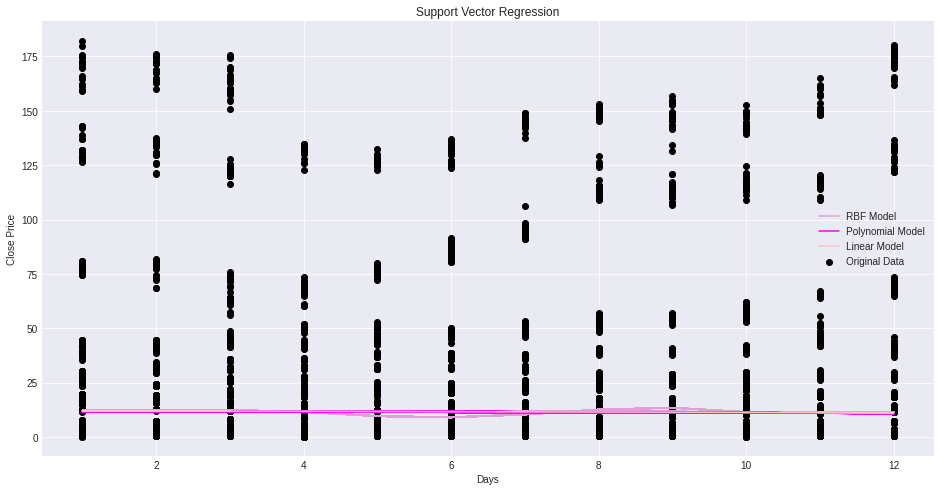

            Date        Open        High         Low       Close       Volume  \
5637  1999-11-01    0.714286    0.720446    0.690804    0.693036  278577600.0   
5636  1999-11-02    0.696429    0.729375    0.690268    0.716518  399235200.0   
5635  1999-11-03    0.728750    0.743304    0.723214    0.727679  328462400.0   
5634  1999-11-04    0.732679    0.762232    0.719821    0.746607  379086400.0   
5633  1999-11-05    0.755536    0.789018    0.750000    0.788482  416808000.0   
...          ...         ...         ...         ...         ...          ...   
4     2022-03-22  165.510000  169.420000  164.910000  168.820000   80979755.0   
3     2022-03-23  167.990000  172.640000  167.650000  170.210000   98062674.0   
2     2022-03-24  171.060000  174.140000  170.210000  174.070000   90131418.0   
1     2022-03-25  173.880000  175.280000  172.750000  174.720000   80281664.0   
0     2022-03-28  172.170000  175.730000  172.000000  175.600000   90371916.0   

      date_regr    date_reg

In [24]:

import pandas as pd

"""
the main module calls all the other modules and have access to all the functions that are needed 
for building the stock model
the main three modules are:
1. get_data()- using this module for getting the last stock price and the history prices.
2. data_preparation()- using this module to prepare the data for the ML models by fixing the types of columns 
fixing the stock splits issue and more.
3. model_lstm()- predict the stock value and is the main ML model in this project.
"""
def main():
  # geting the AAPL stock data using API's
  #get_data.get_apple_stock_data()

  # clean_df = data_pre.basic_prepare(df)

  # reading the raw data that was created by the API's 
  df = pd.read_csv("AP_d1.csv")
  print(df)
  df_clean = data_prep1.basic_prepare(df)
  print(df_clean)
  df_newL = df_clean.copy()
  print(df_newL.head)

  df_clean = df_clean.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low',
                            'close': 'Close', 'volume': 'Volume','date':'Date'})
  df_n = df_clean.copy()
  print(df_clean['Date'])
  print(df_n.columns)
  print(df_clean['Date'])
  result_reg = aapl_reg_models (df_clean) 
  df_n = df_n.iloc[::-1]
  
  print(df_n)
  #New_LSTM(df_n,'2009-03-25', '2022-03-21')
  print(df_n)
#  reg_results = aap_02.aapl_reg_models (df_n)
  #print(reg_results)
  
    #get_data.get_apple_stock_data()
    # raw_data = pd.read_csv('data/apple_daily_data')
    # prepare_data = data_preparation.basic_prepare(raw_data)
    # recursive_predictions = model_lstm.LSTM_prepare_variables(prepare_data)
    # print(recursive_predictions)
    #results = ml_classification_models.classification_models(prepare_data)
    #print(results)


if __name__ == "__main__":
  main()


#Regression models